# Music Genre Classification using Deep Learning

#### DataSet Link: https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification

## MelSpectrogram
#### A Mel-spectrogram is a visual representation of an audio signal that shows how the energy or the power of the signal is distributed across different frequencies over time, but with a twist: the frequence scale is transformed to match how humans perceive sound
#### X-axis(Horizontal): Time
#### Y-axis(Vertical): Frequency, but scaled to match human hearing(mel scale)
#### Color/Intensity: Represents the strength or amplitude of the signal at each time and frequency point.

### Steps to Create a Melspectrogram
#### 1. We took samples of air pressure over tiem to digitally represent an audio signal
#### 2. We mapped the audio signal from the time domain to frequency domain using the fast Fourier transform, and we performd this on overlapping windowed segments of the audio signal.
#### 3. W converted the y-axis(frequencyO to log scale and the color dimension(amplitude) to decibels to form the spectrogram
#### 4. We mapped the y-axis(frequency) onto the mel scale to form the melspectrogram

### Need for fourier transform
#### Revealing Hidden Patterns
#### Human Perception Alignment: Human hearing is more sensitive to changes in frequency rather than changes in amplitude over time.
#### Feature Extraction: Many important audio frequres are based on the frequency content of the signal
#### Noise Reduction and Filterning: Easier to apply filters to isolate certain frequency bands, remove noise, or enhance specific componens of the signal
#### Compression and Encoding: Audio compressing algorithms, such as MP3, rely on frequency domain reqpresentations to efficently encode audio data by removing perceptually less important components

## MelScale
#### Humans hear frequencies in a non-linear way; we are more sensitive to lower frequencies and less sensitive to higher frequencies. The Mel scale adjusts the frequency axis of the spectrogram so that it matches human hearing. Lower frequencies are spaced out more, and higher frequencies are spaced closer together.

### librosa: a python package for music and audio analysis

# -----------------------------------------------------

### Importing Libraries

In [2]:
import os
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.image import resize
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import Audio
import numpy as np
import seaborn as sns

### Visualizing Single Audio

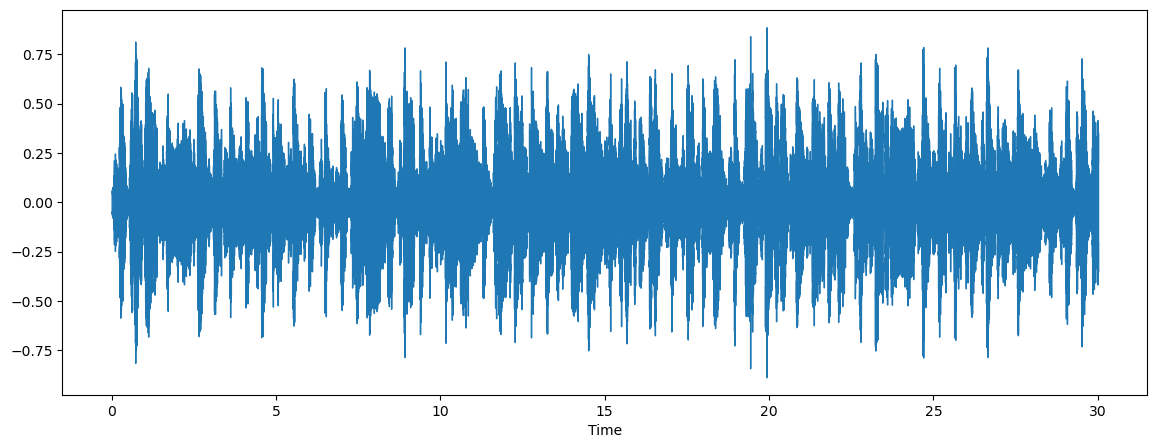

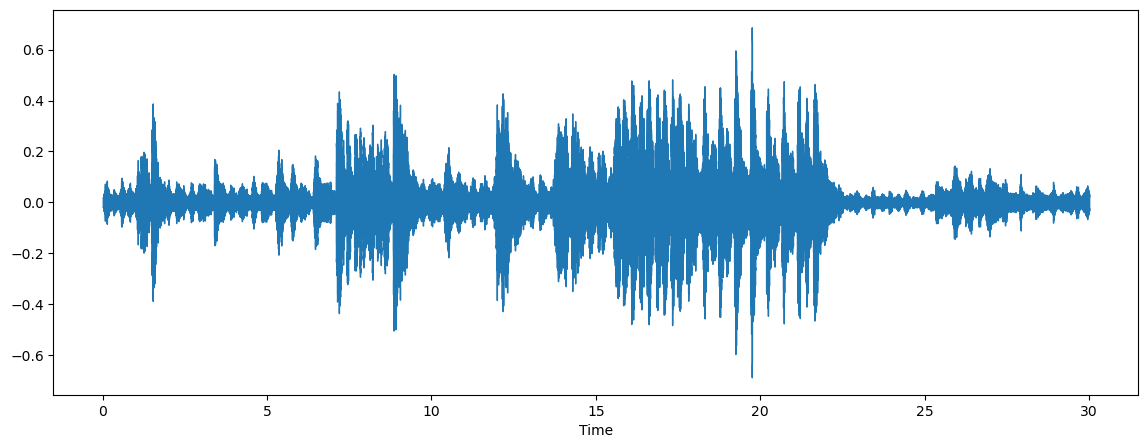

In [3]:
random_file_name_b = "./blues.00000.wav"
random_file_name_j = "./jazz.00000.wav"

y_b, sr_b = librosa.load(random_file_name_b, sr=44100) # y, sample_rate
y_j, sr_j = librosa.load(random_file_name_j, sr=44100) # y, sample rate
plt.figure(figsize=(14,5))
librosa.display.waveshow(y_b, sr=sr_b)
plt.figure(figsize=(14,5))
librosa.display.waveshow(y_j, sr = sr_j)

### Playing Sound

In [4]:
Audio(data=y_b, rate=sr_b)

In [5]:
Audio(data=y_j, rate=sr_j)

### Visualization of chunks of Audio

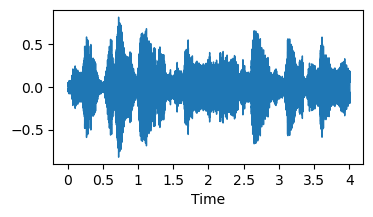

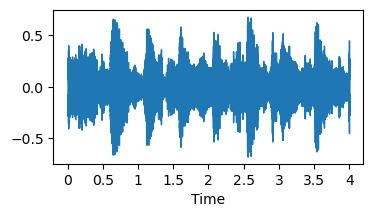

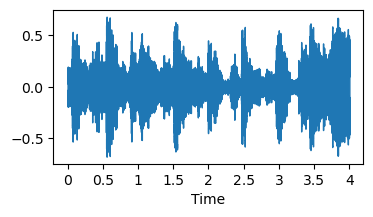

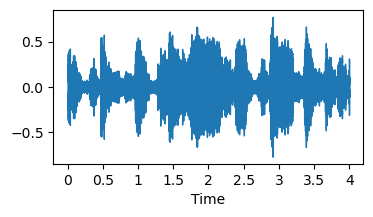

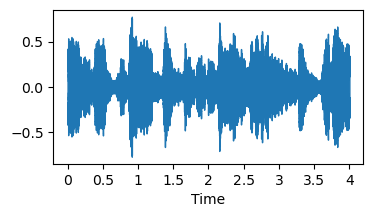

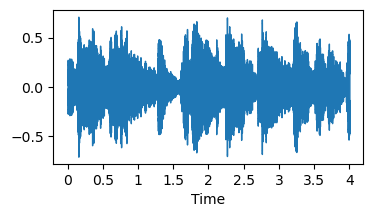

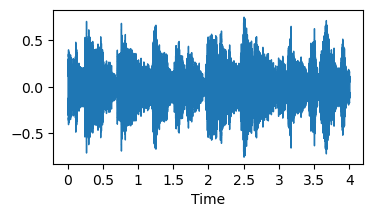

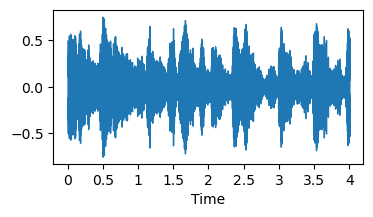

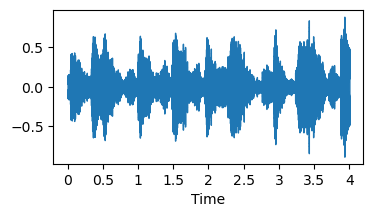

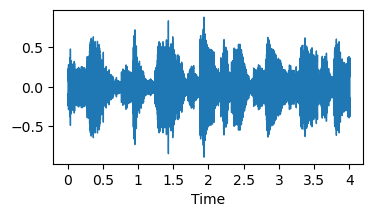

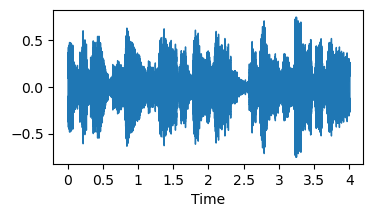

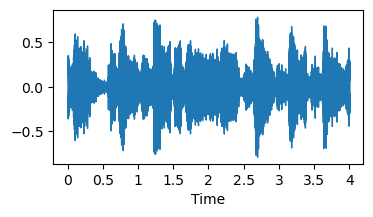

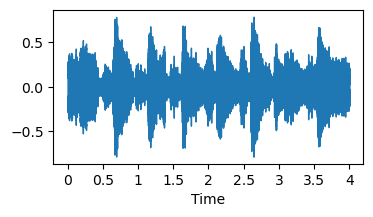

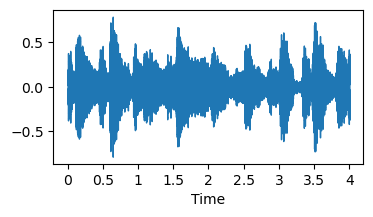

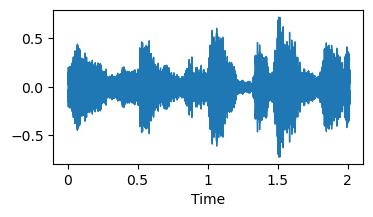

In [6]:
audio_path_b = "./blues.00000.wav"
y_b, sr_b = librosa.load(random_file_name_b, sr=None) # sr = None to keep the original sampling rate

# defining the duration of each chunk and overlap
chunk_duration = 4
overlap_duration = 2

# Convert duration to sample
chunk_samples = chunk_duration * sr_b
overlap_samples = overlap_duration * sr_b

# Calculate the number of chunks
num_chunks = int(np.ceil((len(y_b)-chunk_samples)/(chunk_samples-overlap_samples)))+1

# Iterate over each chunks
for i in range(num_chunks):
    # Calculate start and end indices of the chunk
    start = i*(chunk_samples-overlap_samples)
    end = start+chunk_samples
    # Extract the chunk audio
    chunk = y_b[start:end]
    plt.figure(figsize=(4,2))
    librosa.display.waveshow(chunk, sr= sr_b)
    plt.show()


### Melspectrogram Visualization

In [7]:
# plotting Melspectrogram of Entire Audio
def plot_melspectrogram(y, sr):
    # Compute spectrogram
    spectrogram = librosa.feature.melspectrogram(y=y, sr = sr_b)
    # Convert to decibels (log scale)
    spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
    # Visualize the spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spectrogram_db, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%2.0f dB')
    plt.title("Spectrogram")
    plt.tight_layout()
    plt.show()

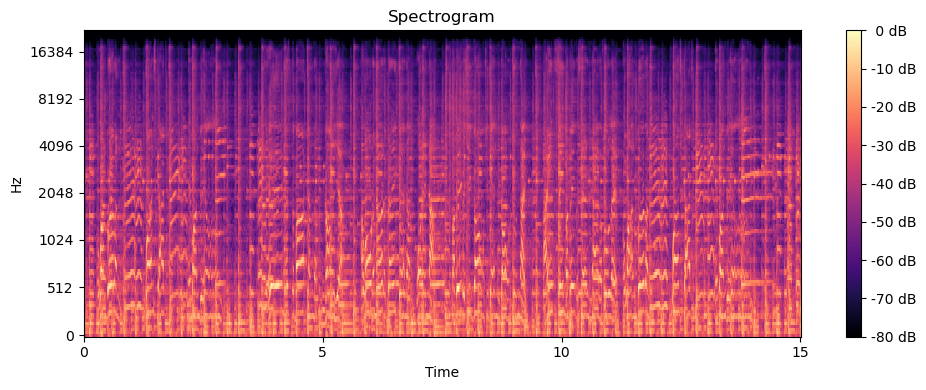

In [8]:
plot_melspectrogram(y_b, sr = 44100)

In [9]:
def plot_melspectrogram_chunks(y, sr):
    # defining the duration of each chunk and overlap
    chunk_duration = 4
    overlap_duration = 2
    
    # Convert duration to sample
    chunk_samples = chunk_duration * sr_b
    overlap_samples = overlap_duration * sr_b
    
    # Calculate the number of chunks
    num_chunks = int(np.ceil((len(y_b)-chunk_samples)/(chunk_samples-overlap_samples)))+1
    
    # Iterate over each chunks
    for i in range(num_chunks):
        # Calculate start and end indices of the chunk
        start = i*(chunk_samples-overlap_samples)
        end = start+chunk_samples
        # Extract the chunk audio
        chunk = y_b[start:end]
        # Melspectrogram part
        spectrogram = librosa.feature.melspectrogram(y=chunk, sr=sr)
        spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
        # Visualize the spectrogram
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(spectrogram_db, sr=sr, x_axis='time', y_axis='mel')
        plt.colorbar(format='%2.0f dB')
        plt.title("Spectrogram")
        plt.tight_layout()
        plt.show()

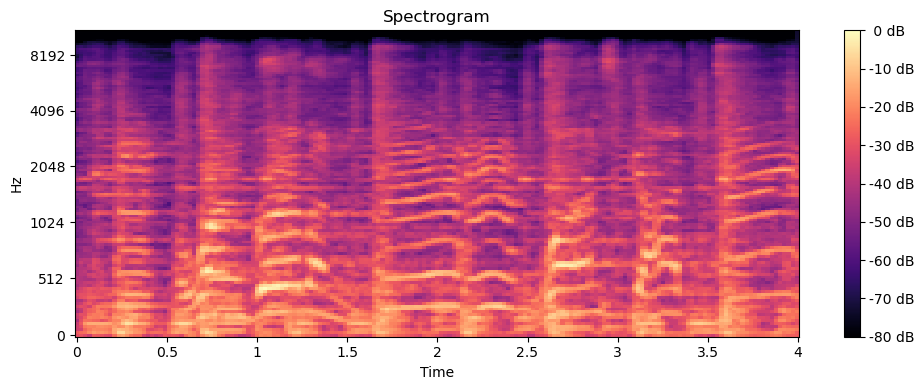

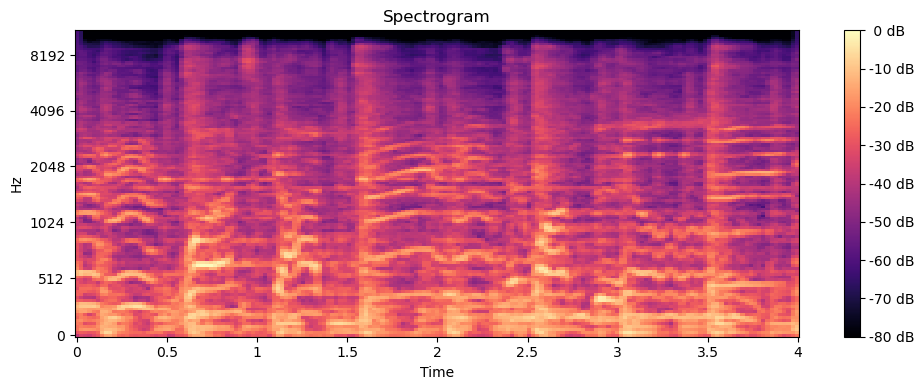

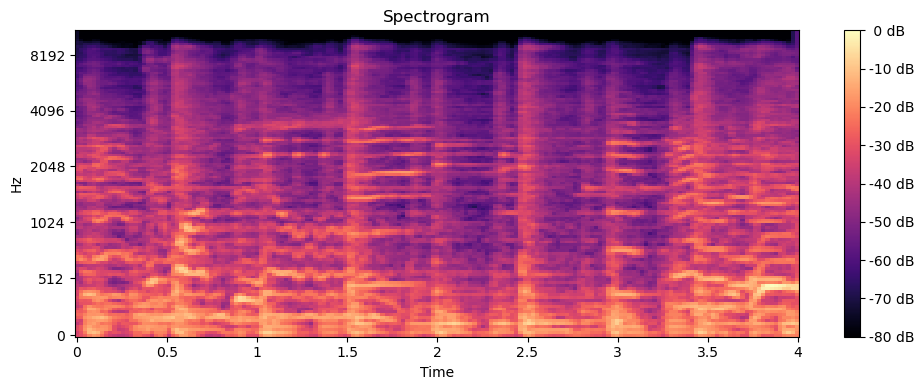

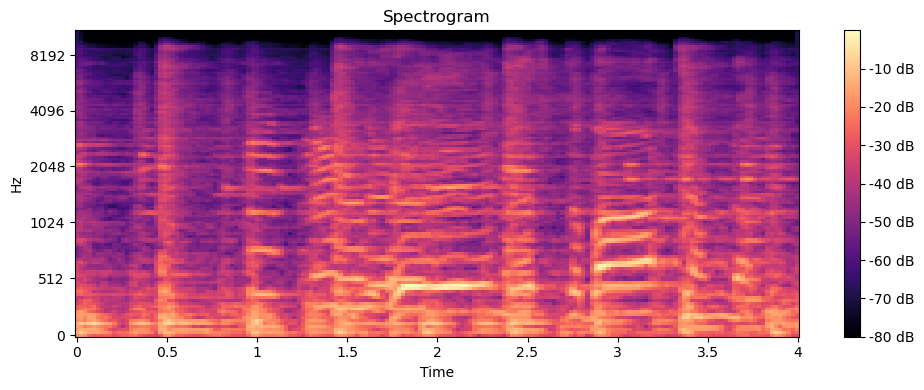

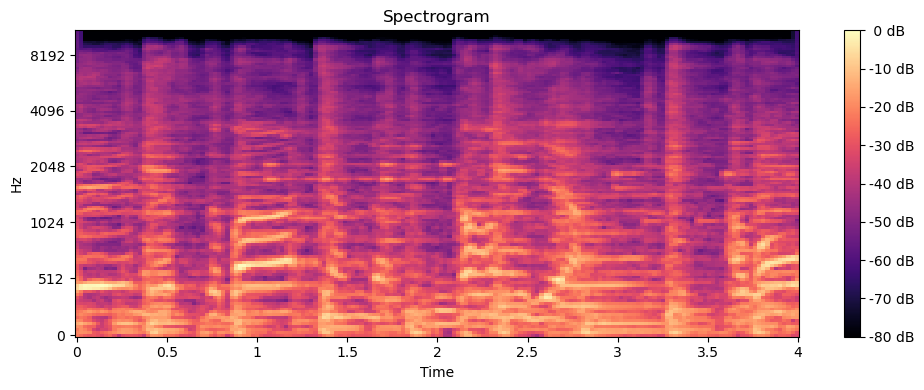

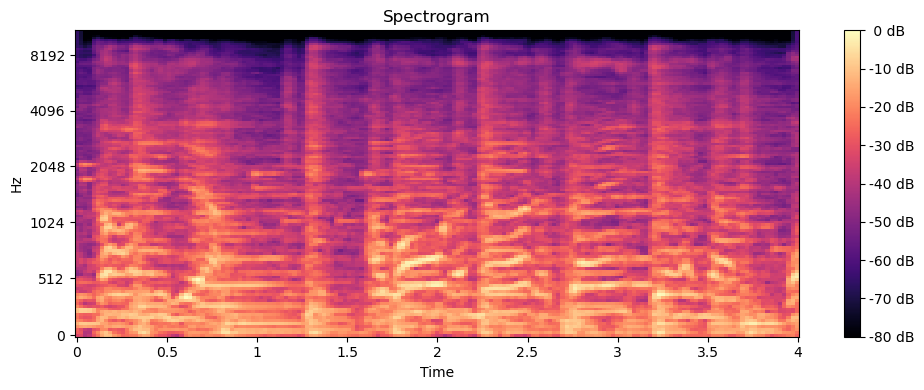

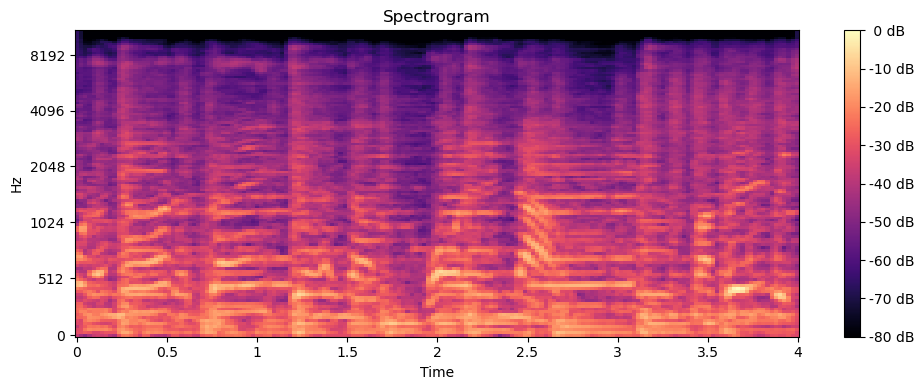

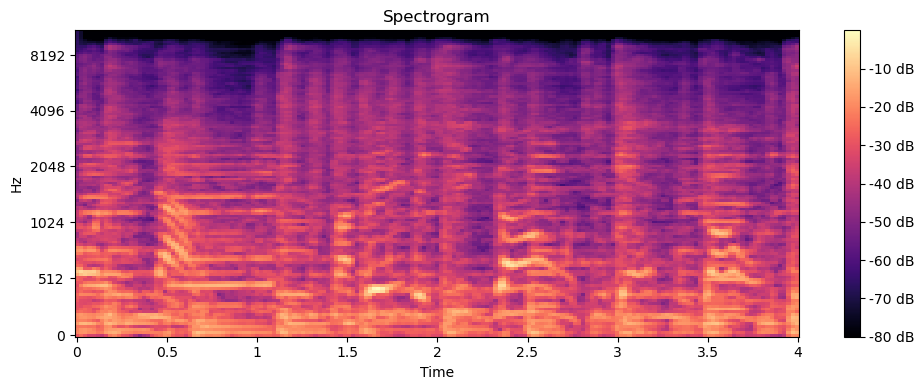

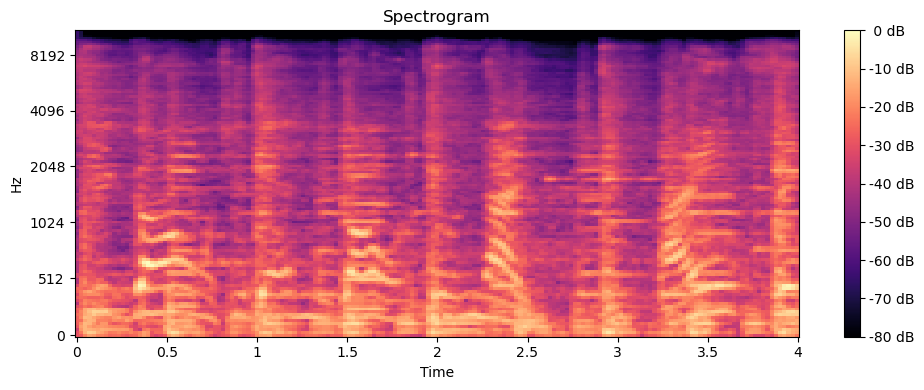

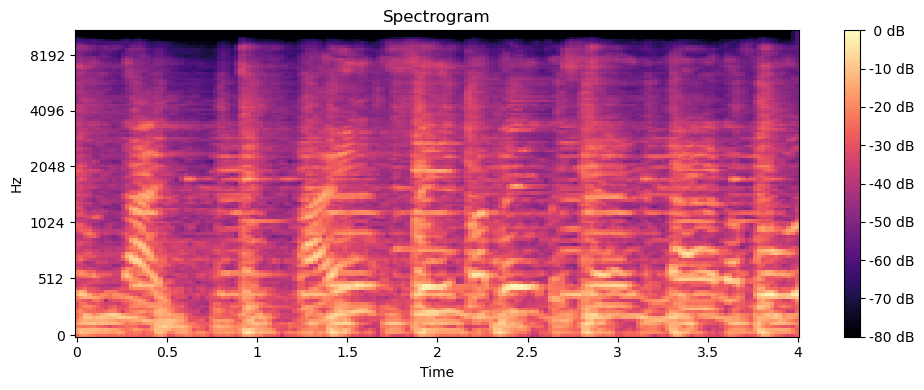

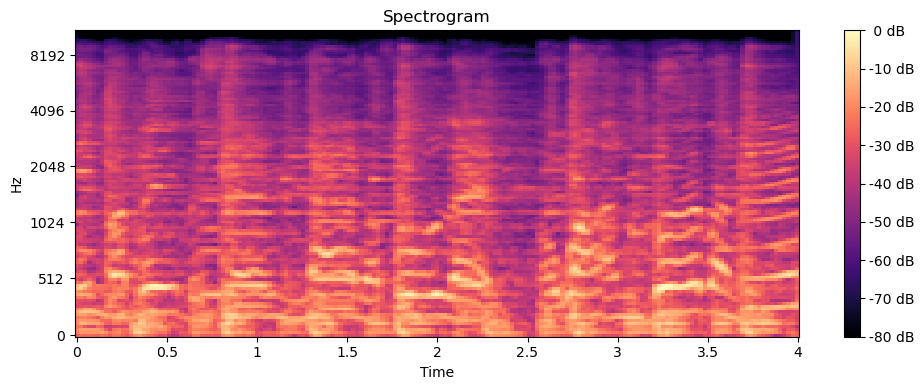

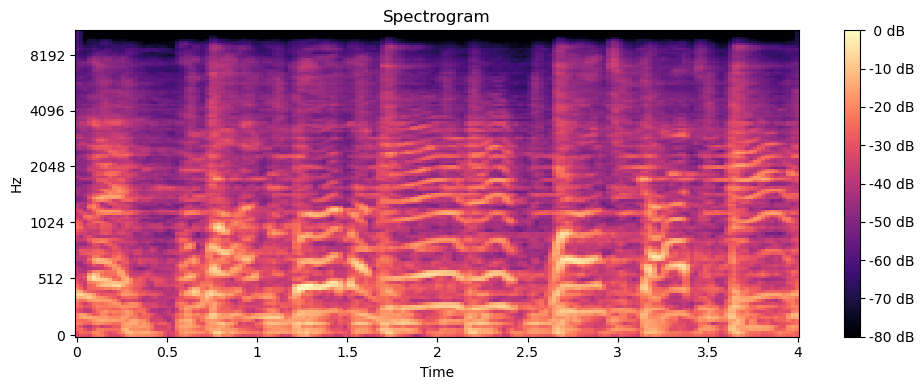

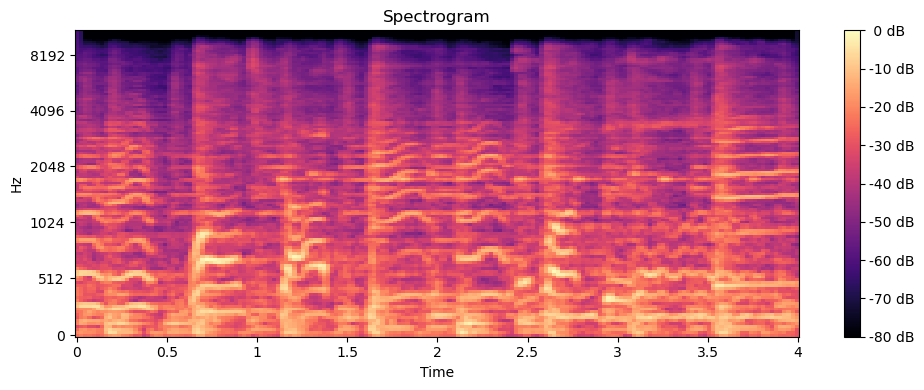

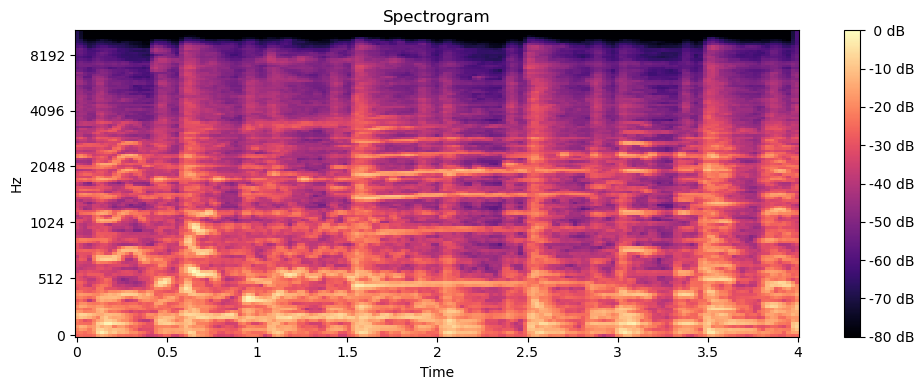

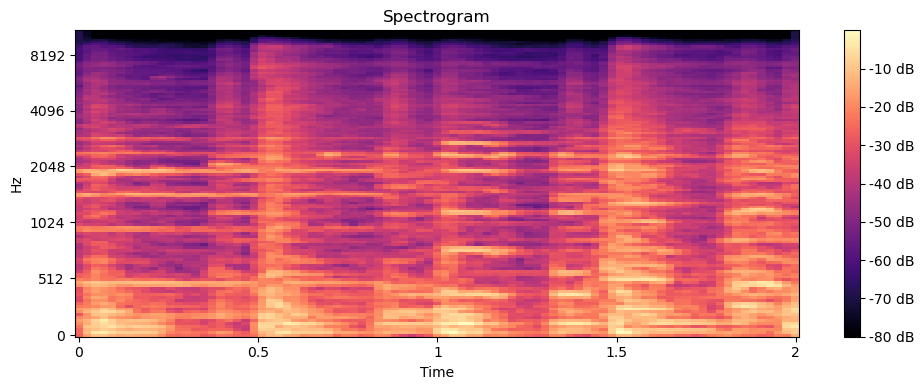

In [10]:
plot_melspectrogram_chunks(y_b, sr_b)

### Data Preprocessing - Final

In [11]:
# define your folder structure
data_dir = "./genres_original"
classes = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz','metal', 'pop', 'reggae', 'rock']

In [12]:
# load and preprocess audio data
def load_and_preprocess_data(data_dir, classess, target_shape=(150,150)): # target_shape should be close to shape of the spectrogram i.e 128*345 use 210*210
                                                                            # if gpu failure occure reduce the target_shape; you may loss some value
                                                                            # but it will work
    data=[]
    labels=[]

    for i_class, class_name in enumerate(classess):
        class_dir = os.path.join(data_dir, class_name)
        print("Processing --> ", class_name)
        for filename in os.listdir(class_dir):
            if filename.endswith('.wav'):
                file_path = os.path.join(class_dir, filename)
                audio_data, sample_rate = librosa.load(file_path, sr=None)
                # performing preprocessing
                # defining the duration of each chunk and overlap
                chunk_duration = 4
                overlap_duration = 2
                
                # Convert duration to sample
                chunk_samples = chunk_duration * sample_rate
                overlap_samples = overlap_duration * sample_rate
                
                # Calculate the number of chunks
                num_chunks = int(np.ceil((len(audio_data)-chunk_samples)/(chunk_samples-overlap_samples)))+1
                
                # Iterate over each chunks
                for i in range(num_chunks):
                    # Calculate start and end indices of the chunk
                    start = i*(chunk_samples-overlap_samples)
                    end = start+chunk_samples
                    # Extract the chunk audio
                    chunk = audio_data[start:end]
                    # Melspectrogram part
                    mel_spectrogram = librosa.feature.melspectrogram(y=chunk, sr=sample_rate)
                    # Resize matrix based on target_shape provided
                    mel_spectrogram = resize(np.expand_dims(mel_spectrogram, axis=-1), target_shape)
                    # Append data to list
                    data.append(mel_spectrogram)
                    labels.append(i_class)
    # return data and labels in array since we have to pass it to neural network
    return np.array(data), np.array(labels)
    

In [13]:
data,labels = load_and_preprocess_data(data_dir, classes)

Processing -->  blues


I0000 00:00:1738153268.610919    4981 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3482 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1


Processing -->  classical
Processing -->  country
Processing -->  disco
Processing -->  hiphop
Processing -->  jazz
Processing -->  metal
Processing -->  pop
Processing -->  reggae
Processing -->  rock


In [14]:
data.shape

(14975, 150, 150, 1)

In [15]:
labels.shape

(14975,)

In [16]:
# one hot encodeing
labels = to_categorical(labels, num_classes=len(classes))
labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [17]:
labels.shape

(14975, 10)

### Splitting of Dataset into training and test set

In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(data, labels, test_size=0.2, random_state=2)

In [19]:
X_train.shape

(11980, 150, 150, 1)

In [20]:
X_test.shape

(2995, 150, 150, 1)

In [21]:
Y_train.shape

(11980, 10)

In [22]:
Y_test.shape

(2995, 10)

### Building Model

In [23]:
model = tf.keras.models.Sequential()

In [24]:
X_train[0].shape

(150, 150, 1)

In [25]:
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=X_train[0].shape))
model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=2, strides=2))

model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=2, strides=2))

model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=2, strides=2))

model.add(Dropout(0.3)) # To solve the problem of overfittting

model.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=256, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=2, strides=2))

model.add((Conv2D(filters=512, kernel_size=3, padding='same', activation='relu')))
model.add((Conv2D(filters=512, kernel_size=3, activation='relu')))
model.add(MaxPool2D(pool_size=2, strides=2))

model.add(Dropout(0.3)) # To solve the problem of overfittting

model.add(Flatten())

model.add(Dense(units=1200, activation='relu')) # sigmoid function is more costly so using relu to speed up the performance

model.add(Dropout(0.45)) # To solve the problem of overfittting

# Output layer
model.add(Dense(units=len(classes), activation='softmax'))


/home/himanshu/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [26]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 148, 148, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 74, 74, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 72, 72, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 36, 36, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 17, 17, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 15, 15, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 7, 7, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 5, 5, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1200)           │     2,458,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        12,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,182,458 (27.40 MB)

 Trainable params: 7,182,458 (27.40 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
# train the model
training_history = model.fit(X_train, Y_train, epochs=1, batch_size=32, validation_data=(X_test, Y_test))

2025-01-29 17:23:29.010558: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2113272000 exceeds 10% of free system memory.
2025-01-29 17:23:30.193300: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2113272000 exceeds 10% of free system memory.
I0000 00:00:1738151614.223114   18068 service.cc:148] XLA service 0x7a805c016800 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738151614.223201   18068 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1050, Compute Capability 6.1
2025-01-29 17:23:34.531990: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1738151616.371910   18068 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-01-29 17:23:41.670443: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially b

ResourceExhaustedError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/home/himanshu/anaconda3/lib/python3.12/runpy.py", line 198, in _run_module_as_main

  File "/home/himanshu/anaconda3/lib/python3.12/runpy.py", line 88, in _run_code

  File "/home/himanshu/anaconda3/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/himanshu/anaconda3/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/himanshu/anaconda3/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/himanshu/anaconda3/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/home/himanshu/anaconda3/lib/python3.12/asyncio/base_events.py", line 641, in run_forever

  File "/home/himanshu/anaconda3/lib/python3.12/asyncio/base_events.py", line 1986, in _run_once

  File "/home/himanshu/anaconda3/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/home/himanshu/anaconda3/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/himanshu/anaconda3/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/himanshu/anaconda3/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/himanshu/anaconda3/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/himanshu/anaconda3/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/himanshu/anaconda3/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/himanshu/anaconda3/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/himanshu/anaconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/himanshu/anaconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/himanshu/anaconda3/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/himanshu/anaconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/himanshu/anaconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/himanshu/anaconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_17968/2143295626.py", line 2, in <module>

  File "/home/himanshu/anaconda3/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/himanshu/anaconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 368, in fit

  File "/home/himanshu/anaconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 216, in function

  File "/home/himanshu/anaconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 129, in multi_step_on_iterator

Out of memory while trying to allocate 1622141584 bytes.
	 [[{{node StatefulPartitionedCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_multi_step_on_iterator_94440]

In [ ]:
model.save("Music_Genre_Classification_model.h5")

In [ ]:
training.history.history

In [ ]:
# Saving history in json
with open('training_history.json', 'w') as f:
    json.dump(training.history.history, f)

In [ ]:
with open('training_history.json', 'r') as json_file:
    training_history_data = json.load(json_file)
training_history_data.keys()

### Model Evaluation

In [ ]:
# model evaluation in training set
train_loss, train_accuracy = model.evaluate(X_train, Y_train)
train_loss, train_accuracy

In [ ]:
# model evaluation in validation set
val_loss, val_accuracy = model.evaluate(X_train, Y_train)
val_loss, val_accuracy

### Accuracy and Loss visualization

In [ ]:
# visualization of loss
epochs = [i for i in range(1, 31)]
plt.plot(epochs, training_history_data['loss'], label="Training Loss", color="blue")
plt.plot(epochs, training_history_data['val_loss'], label="Validation Loss", color="green")
plt.xlabel("no of epochs")
plt.ylabel("Loss")
plt.title("Visualization of loss result")
plt.legend()
plt.show()

In [ ]:
# visualization of Accuracy
epochs = [i for i in range(1, 31)]
plt.plot(epochs, training_history_data['accuracy'], label="Training Accuracy", color="blue")
plt.plot(epochs, training_history_data['val_accuracy'], label="Validation Accuracy", color="green")
plt.xlabel("no of epochs")
plt.ylabel("Accuracy")
plt.title("Visualization of Accuracy result")
plt.legend()
plt.show()

### Loading Model

In [27]:
# Reload model variable
model = tf.keras.models.load_model("Music_Genre_Classification_model.h5")
model.summary()

/home/himanshu/anaconda3/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 148, 148, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 74, 74, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 72, 72, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 36, 36, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 17, 17, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 15, 15, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 7, 7, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 5, 5, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1200)           │     2,458,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        12,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,182,460 (27.40 MB)

 Trainable params: 7,182,458 (27.40 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

### Precision, Recall, Confusion Matrix

In [28]:
X_test.shape

(2995, 150, 150, 1)

In [29]:
y_pred = model.predict(X_test)
y_pred

I0000 00:00:1738153404.932682    5101 service.cc:148] XLA service 0x7a0ca40032b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738153404.932896    5101 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1050, Compute Capability 6.1
2025-01-29 17:53:24.950001: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1738153405.017736    5101 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-01-29 17:53:25.971685: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[32,32,148,148]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,150,150]{3,2,1,0}, f32[32,32,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activa

 5/94 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step

I0000 00:00:1738153411.528652    5101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

2025-01-29 17:53:35.618066: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[19,32,148,148]{3,2,1,0}, u8[0]{0}) custom-call(f32[19,32,150,150]{3,2,1,0}, f32[32,32,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-01-29 17:53:36.282953: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[19,64,74,74]{3,2,1,0}, u8[0]{0}) custom-call(f32[19,32,74,74]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend

94/94 ━━━━━━━━━━━━━━━━━━━━ 14s 81ms/step


array([[1.0733764e-02, 2.2420841e-03, 6.5463551e-05, ..., 1.1889889e-03,
        8.0407708e-04, 1.2163063e-04],
       [1.4348971e-11, 1.8551512e-13, 2.6491112e-10, ..., 9.9998999e-01,
        5.5024753e-07, 4.4190824e-07],
       [8.9191243e-10, 4.1257193e-09, 4.9724954e-04, ..., 1.8039881e-10,
        3.0212655e-11, 9.9949753e-01],
       ...,
       [5.6014127e-11, 2.4070339e-15, 2.9818114e-12, ..., 6.7792752e-07,
        1.2441633e-09, 1.9847479e-07],
       [1.0069800e-12, 8.1977269e-19, 1.2590083e-14, ..., 9.8985673e-09,
        6.1876584e-09, 8.2388915e-11],
       [5.0852034e-10, 2.5067893e-13, 2.1904697e-11, ..., 4.8454487e-12,
        2.6828305e-12, 5.1643063e-05]], dtype=float32)

In [30]:
y_pred.shape

(2995, 10)

In [31]:
predicted_categories = np.argmax(y_pred, axis=1)
predicted_categories

array([5, 7, 9, ..., 4, 4, 6])

In [32]:
Y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [33]:
Y_test.shape

(2995, 10)

In [35]:
true_categories = np.argmax(Y_test, axis=1)
true_categories

array([5, 7, 9, ..., 4, 4, 6])

In [36]:
classes

['blues',
 'classical',
 'country',
 'disco',
 'hiphop',
 'jazz',
 'metal',
 'pop',
 'reggae',
 'rock']

In [37]:
cm = confusion_matrix(true_categories, predicted_categories)
# Precision Recall --> F1_Score
print(classification_report(true_categories, predicted_categories, target_names=classes))

              precision    recall  f1-score   support

       blues       0.98      0.92      0.95       316
   classical       0.98      0.99      0.99       297
     country       0.84      0.98      0.90       294
       disco       0.99      0.98      0.99       282
      hiphop       1.00      0.98      0.99       322
        jazz       0.95      0.99      0.97       289
       metal       0.99      0.99      0.99       305
         pop       0.99      0.96      0.97       277
      reggae       0.99      0.95      0.97       303
        rock       0.98      0.92      0.95       310

    accuracy                           0.97      2995
   macro avg       0.97      0.97      0.97      2995
weighted avg       0.97      0.97      0.97      2995



In [38]:
cm

array([[291,   1,  22,   0,   0,   1,   0,   0,   0,   1],
       [  0, 295,   0,   0,   0,   2,   0,   0,   0,   0],
       [  0,   0, 289,   0,   0,   5,   0,   0,   0,   0],
       [  0,   0,   2, 276,   0,   0,   0,   0,   1,   3],
       [  1,   0,   0,   0, 315,   0,   1,   4,   1,   0],
       [  0,   3,   0,   0,   0, 286,   0,   0,   0,   0],
       [  0,   0,   1,   0,   0,   0, 303,   0,   0,   1],
       [  1,   0,   5,   2,   0,   2,   1, 265,   0,   1],
       [  3,   0,   9,   0,   1,   1,   0,   0, 289,   0],
       [  0,   2,  17,   0,   0,   3,   2,   0,   1, 285]])

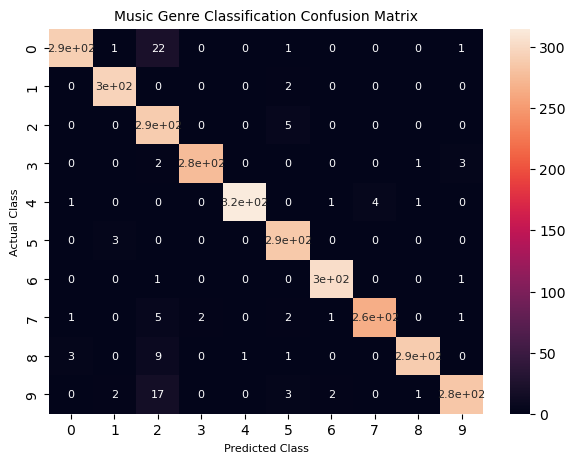

In [44]:
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, annot_kws={"size":8})
plt.xlabel("Predicted Class", fontsize = 8)
plt.ylabel("Actual Class", fontsize = 8)
plt.title("Music Genre Classification Confusion Matrix", fontsize=10)

plt.show()